## Ensemble Model comprising of the trained YOLov5 and Faster RCNN models for survivor detection in Post Disaster Scenarios

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive # creating a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
%cd /mydrive/Final_Year_Project/RCNN

/
Mounted at /content/gdrive
/content/gdrive/My Drive/Final_Year_Project/RCNN


In [ ]:
%cd /mydrive/Final_Year_Project/Saved_Models

/content/gdrive/My Drive/Final_Year_Project/Saved_Models


In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-jeur6i61
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-jeur6i61
  Resolved https://github.com/facebookresearch/detectron2.git to commit 1f84ebbf5af96eae71e2c0476d49e9cbdc5b190f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filen

In [ ]:
import cv2
import numpy as np
import torch, detectron2
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2 import model_zoo
from detectron2.data import build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor
from PIL import Image
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="9KG0WhvnpHGdnlOuXdur")
project = rf.workspace("final-year-project-deylr").project("ensemble-3ipxs")
dataset = project.version(1).download("coco")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.6 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=a2a1ea1b819da8e21586829b415e10ac1cedf5183d05289863a9894c769056c3
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to Ensemble-1 in coco:: 100%|██████████| 248/248 [00:02<00:00, 102.49it/s]


In [ ]:
import os
DATA_SET_NAME = dataset.name.replace(" ", "-")
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
# TRAIN SET
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "train")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME, 
    metadata={}, 
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH, 
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# TEST SET
TEST_DATA_SET_NAME = f"{DATA_SET_NAME}-test"
TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "test")
TEST_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "test", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TEST_DATA_SET_NAME, 
    metadata={}, 
    json_file=TEST_DATA_SET_ANN_FILE_PATH, 
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

# VALID SET
VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "valid")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME, 
    metadata={}, 
    json_file=VALID_DATA_SET_ANN_FILE_PATH, 
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

[
    data_set
    for data_set
    in MetadataCatalog.list()
    if data_set.startswith(DATA_SET_NAME)
]

['Ensemble-train', 'Ensemble-test', 'Ensemble-valid']

In [ ]:
from detectron2.config import get_cfg
cfg = get_cfg()
# Load the test image
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

dataset_entry = dataset_train[0]
image = cv2.imread(dataset_entry["file_name"])

# Use the Faster R-CNN model to detect objects
cfg.MODEL.WEIGHTS = '/content/gdrive/MyDrive/Final_Year_Project/Saved_Models/RCNN.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)
output_frcnn = predictor(image)

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

backbone.res2.0.conv1.norm.{bias, weight}
backbone.res2.0.conv1.weight
backbone.res2.0.conv2.norm.{bias, weight}
backbone.res2.0.conv2.weight
backbone.res2.0.conv3.norm.{bias, weight}
backbone.res2.0.conv3.weight
backbone.res2.0.shortcut.norm.{bias, weight}
backbone.res2.0.shortcut.weight
backbone.res2.1.conv1.norm.{bias, weight}
backbone.res2.1.conv1.weight
backbone.res2.1.conv2.norm.{bias, weight}
backbone.res2.1.conv2.weight
backbone.res2.1.conv3.norm.{bias, weight}
backbone.res2.1.conv3.weight
backbone.res2.2.conv1.norm.{bias, weight}
backbone.res2.2.conv1.weight
backbone.res2.2.conv2.norm.{bias, weight}
backbone.res2.2.conv2.weight
backbone.res2.2.conv3.norm.{bias, weight}
backbone.res2.2.conv3.weight
backbone.res3.0.conv1.norm.{bias, weight}
backbone.res3.0.conv1.weight
backbone.res3.0.conv2.norm.{bias, weight}
backbone.res3.0.conv2.weight
backbone.res3.0.conv3.norm.{bias, weight}
backbone.re

In [ ]:
# Use the YOLOv5 model to detect objects
from torchvision import datasets, transforms
from PIL import Image

# Load the image
img = Image.open('/content/gdrive/MyDrive/Final_Year_Project/Saved_Models/test_image.jpg')
model_yolov5 = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/gdrive/MyDrive/Final_Year_Project/YOLOv5/yolov5/runs/train/yolov5s_results/weights/best.pt', force_reload=True) 
# model_yolov5.to(device)
model_yolov5.eval()
# Define data transformation
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)
# Convert the tensor to PyTorch format
img_tensor = img_tensor.float()
output_yolov5 = model_yolov5(img_tensor)
# output_yolov5 = non_max_suppression(output_yolov5, conf_thres=0.5, iou_thres=0.5)
# with torch.no_grad():
    # image_tensor = transforms(image).unsqueeze(0).to(device)
    # image_tensor = transform(image)
    

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-4-16 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7249215 parameters, 0 gradients
Adding AutoShape... 


requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


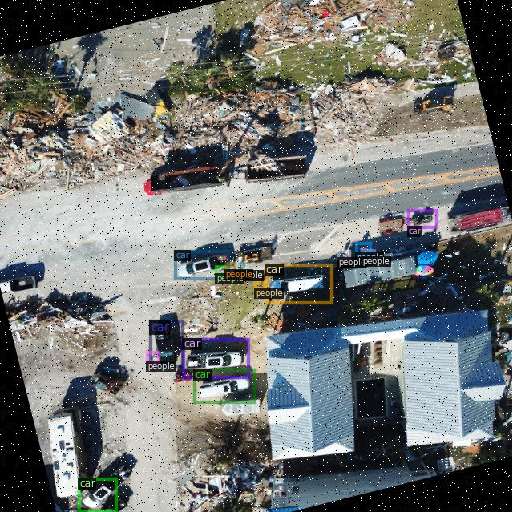

In [ ]:
# Visualize the results from Faster R-CNN
# from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
import cv2
from google.colab.patches import cv2_imshow

visualizer = Visualizer(
    image[:, :, ::-1],
    metadata=metadata, 
    scale=0.8, 
    instance_mode=ColorMode.IMAGE_BW
)

out = visualizer.draw_dataset_dict(dataset_entry)
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Visualize the results from YOLOv5
%cd /content/gdrive/MyDrive/Final_Year_Project/YOLOv5/yolov5/
!python detect.py --weights /content/gdrive/MyDrive/Final_Year_Project/YOLOv5/yolov5/runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source /content/gdrive/MyDrive/Final_Year_Project/Saved_Models/test_image_3.jpg

/content/gdrive/MyDrive/Final_Year_Project/YOLOv5/yolov5
detect: weights=['/content/gdrive/MyDrive/Final_Year_Project/YOLOv5/yolov5/runs/train/yolov5s_results/weights/best.pt'], source=/content/gdrive/MyDrive/Final_Year_Project/Saved_Models/test_image_3.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7249215 parameters, 0 gradients
image 1/1 /content/gdrive/MyDrive/Final_Year_Project/Saved_Models/test_image_3.jpg: 416x416 7 cars, 8.6ms
Speed: 0.6ms pre-process, 8.6ms inference, 101.0ms NMS per image at 

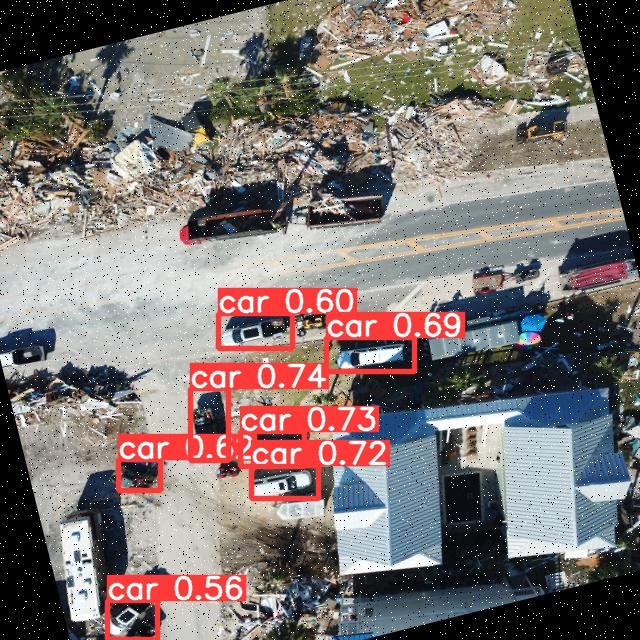

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/gdrive/MyDrive/Final_Year_Project/YOLOv5/yolov5/runs/detect/exp7/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [ ]:
def ensemble_results(models, images, conf_threshold, iou_threshold):
    """
    Returns the ensemble detection results for multiple models on multiple images.

    Parameters:
    models (list): A list of PyTorch models to use for object detection.
    images (list): A list of images to detect objects in.
    conf_threshold (float): The confidence threshold below which predictions are suppressed.
    iou_threshold (float): The IoU threshold above which overlapping predictions are suppressed.

    Returns:
    list: A list of dictionaries containing the detection results for each image.
    """

    results = []

    # Detect objects in each image using each model
    for image in images:
        detection_results = []

        for model in models:
            predictions = model.detect(image)
            detection_results.append(predictions)

        # Ensemble the detection results
        ensemble_predictions = torch.cat(detection_results, dim=0)
        ensemble_predictions = non_max_suppression(ensemble_predictions, conf_threshold, iou_threshold)

        # Convert the detection results to a dictionary format
        detection_dict = {'boxes': [], 'scores': [], 'labels': []}

        for bbox in ensemble_predictions:
            detection_dict['boxes'].append(bbox[0:4].tolist())
            detection_dict['scores'].append(bbox[5].item())
            detection_dict['labels'].append(int(bbox[6].item()))

        results.append(detection_dict)

    return results

In [ ]:
models = [output_frcnn, output_yolov5]
result_ensemble = ensemble_results(models, image, 0.5, 0.5)
dataset_entry = result_ensemble.detect(image)

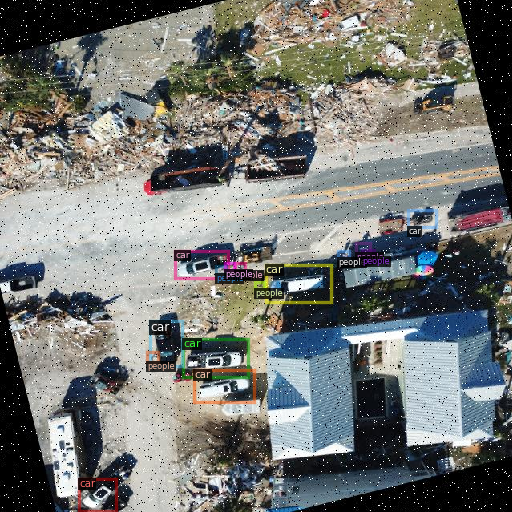

In [ ]:
visualizer = Visualizer(
    image[:, :, ::-1],
    metadata=metadata, 
    scale=0.8, 
    instance_mode=ColorMode.IMAGE_BW
)

out = visualizer.draw_dataset_dict(dataset_entry)
cv2_imshow(out.get_image()[:, :, ::-1])